In [1]:
from git import Repo
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 15)

In [2]:
# Path to your Git repository
repo_path = r"C:\Users\Tom\documents\coding\cityalarms\.git"

# Open the repository
repo = Repo(repo_path)

# Access the commit history
commits_full = list(repo.iter_commits())

In [3]:
# Trim data. Get rid of first and last commits
commits_reduced = commits_full[1:-1]

# Iterate over the commits and extract the necessary information
commits = []
for commit in reversed(commits_reduced):
    commits.append(
        {
            "id": commit.hexsha,
            "date": commit.authored_datetime.date(),
            "message": commit.message.replace("\n", ""),
            "insertions": commit.stats.total["insertions"],
            "deletions": commit.stats.total["deletions"],
            "total_edits": commit.stats.total["lines"],
        }
    )
df_commits = pd.DataFrame(commits)

In [4]:
# Give a penalty to commits with certain messages in them
# e.g. ones that have a large amount of code insertions or deletions

multiplication_factor = 1/2

mask = df_commits["message"].str.contains("new typescript react app", case=False)
df_commits.loc[mask, "insertions"] = (
    df_commits.loc[mask, "insertions"] * multiplication_factor
)
df_commits.loc[mask, "deletions"] = (
    df_commits.loc[mask, "deletions"] * multiplication_factor
)

In [5]:
# Sort the commits dataframe by date in ascending order
df_commits = df_commits.sort_values("date")

# Get total amount of code after each commit
net_code_added = df_commits["insertions"] - df_commits["deletions"]
df_commits["total_code"] = net_code_added.cumsum()

# New dataframe with insertions, deletions and total code edits per day
df_days = (
    df_commits.groupby("date")
    .agg({"insertions": "sum", "deletions": "sum", "total_edits": "sum", "total_code": "max"})
    .reset_index()
)

# Get number of commits
df_days["commits"] = df_commits.groupby("date").size().values

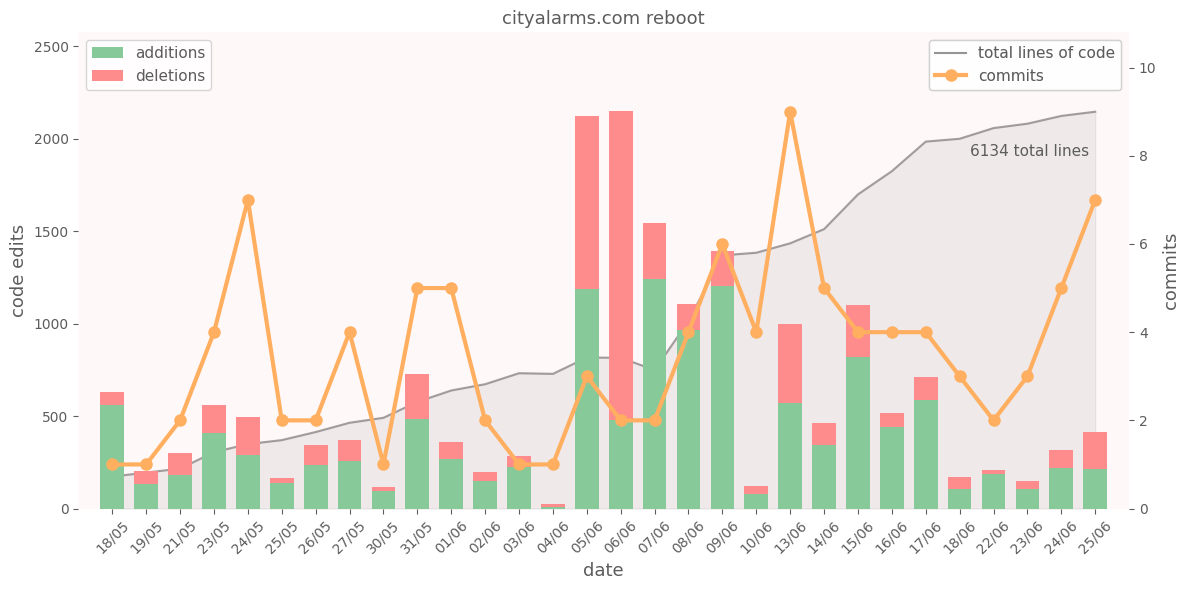

In [35]:
green = "#88c999"
red = "#ff8c8c"
orange = "#ffaf5f"
grey = "#5c5c5c"
grey2 = grey

dates = [date.strftime("%d/%m") for date in df_days["date"]]
# extended_dates = dates.copy().append("")
# final_code_count = df_days["total_code"].iloc[-1]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for insertions and deletions
ax1.bar(dates, df_days["insertions"], label="additions", width=0.7, color=green)
ax1.bar(
    dates,
    df_days["deletions"],
    label="deletions",
    width=0.7,
    color=red,
    bottom=df_days["insertions"],
)

# Create a secondary y-axis for the number of commits
ax2 = ax1.twinx()
ax2.plot(
    dates,
    df_days["commits"],
    color=orange,
    marker="o",
    markersize=8,
    linewidth=3,
    label="commits",
)

# plot total amount of code
ax3 = ax1.twinx()
# ax3.plot(
#     dates,
#     df_days["total_code"],
#     label="total lines of code",
#     color=grey,
#     alpha=0.6,
# )
ax3.plot(
    dates,
    df_days["total_code"],
    label="total lines of code",
    color=grey,
    alpha=0.6,
)
ax3.fill_between(dates, df_days["total_code"], color=grey, alpha=0.1)
ax3.set_yticks([])
ax3.set_yticklabels([])

# Set axis labels and title
ax1.set_title("cityalarms.com reboot", fontsize=13, color=grey2)
ax1.set_xlabel("date", fontsize=13, color=grey2)
ax1.set_ylabel("code edits", fontsize=13, color=grey2)
ax2.set_ylabel("commits", fontsize=13, color=grey2)

# Rotate and align x-axis tick labels for both subplots
ax1.tick_params(axis="x", rotation=45, colors=grey2)
ax2.tick_params(axis="x", rotation=45, colors=grey2)

# Make y=0 aligned with bottom of plot
ax1.set_ylim(bottom=0, top=0.6 * df_days["total_edits"].max())
ax2.set_ylim(bottom=0, top=1.2 * df_days["commits"].max())
ax3.set_ylim(bottom=0, top=1.2 * df_days["total_code"].max())

# Display legends
legend_ax1 = ax1.legend(loc="upper left", fontsize=11)
legend_ax2 = ax2.legend(loc="upper right", fontsize=11)

# Create a separate legend for ax3
legend_ax3 = ax3.legend(loc="center right", fontsize=11)
legend_ax3.remove()

# Combine the handles and labels from both legends
handles = legend_ax3.legend_handles + legend_ax2.legend_handles
labels = [text.get_text() for text in legend_ax3.get_texts()] + [
    text.get_text() for text in legend_ax2.get_texts()
]

# Create a new legend with the combined handles and labels
legend_combined = ax2.legend(handles, labels, loc="upper right", fontsize=11)

# Add the combined legend to the plot
ax2.add_artist(legend_combined)

# Color the font in the legends
for text in legend_ax1.get_texts():
    text.set_color(grey2)
for text in legend_combined.get_texts():
    text.set_color(grey2)

# Background color
ax1.set_facecolor("pink")
ax1.patch.set_alpha(0.1)
ax1.patch.set_zorder(0)

# Adjust the layering of the plots using zorder
ax1.set_zorder(2)
ax2.set_zorder(3)
ax3.set_zorder(1)

# Frame colours
for ax in [ax1, ax2, ax3]:
    ax.tick_params(color=grey2, labelcolor=grey2)
    for spine in ax.spines.values():
        spine.set_edgecolor(grey2)
        spine.set_visible(False)

# Reduce the x-axis margins
margin = 1  # Adjust the margin size as needed
ax.set_xlim(-margin, len(dates) - 1 + margin)

# Annotations
font_properties = fm.FontProperties(size=11)
ax1.annotate(
    "6134 total lines",
    xy=(0, 0),
    xytext=(len(dates) - 4.7, 1910),
    fontproperties=font_properties,
    color=grey2,
)

# font_properties = fm.FontProperties(family="cursive", size=12)
# ax1.annotate(
#     "Example Annotation",
#     xy=(10, 5),
#     xytext=(20, 50),
#     arrowprops=dict(arrowstyle="->"),
#     fontproperties=font_properties,
# )


plt.tight_layout()
plt.show()